In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import PIL
from scipy.io import wavfile
import torchaudio
from IPython.display import Audio, display

In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

# Proyecto 3: Speech Recognition

Este proyecto consiste en entrenar una red neuronal para que pueda reconocer los camandos dados en los archivos de audio en [esta dataset](https://www.kaggle.com/tommyngx/fluent-speech-corpus)

**[OPTIONAL]**

Pueden crear sus propios dataset con su microfono. Por ejemplo: audio con diciendi ciertos comandos como: "apagar", "prender", etc.

## Reporte

**Modificar esto si se utiliza otra dataset, explicar el tipo de dataset**

In [ ]:
# Sin modificaciones
!kaggle datasets download tommyngx/fluent-speech-corpus
!unzip fluent-speech-corpus.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e4858660-4510-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e48a36c0-450f-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e5cbd3f0-450e-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e60046e0-450d-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e6175480-4511-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e67c9b70-4510-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e6cc5e90-450f-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e7980870-450e-11e9-9539-7f047cfe24d1.w

**Si se utiliza otra dataset, explicar como se debe cambiar esta clase**

In [ ]:
# Sin Modificaciones

class MyDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None,train=True,list_transcription=None):
    #donde está el audio y que es lo que se decía en ese audio
    self.wav_df = pd.read_csv(f"fluent_speech_commands_dataset/data/{'train' if train else 'test'}_data.csv")
    self.list_transcription = list_transcription
    if self.list_transcription is None:
      self.list_transcription = list(set(self.wav_df.transcription))
    self.dict_transcription = {k:v for v,k in enumerate(self.list_transcription)}
    self.transform = transform
    self.max_length = 30000

  def __getitem__(self,idx):
    _, x = wavfile.read(os.path.join("fluent_speech_commands_dataset",self.wav_df.path.iloc[idx]))
    x = torch.from_numpy(x)
    x = x/ 4000.0
    if self.transform is not None:
      x = self.transform(x)
    x = x[:self.max_length]
    N, = x.shape
    x = x.reshape(1,-1)
    x = torch.functional.F.pad(x,(0,(self.max_length - N)),mode="constant",value=0.0)
 #   S = spectrogram(x)
    y = self.dict_transcription[self.wav_df.transcription.iloc[idx]]
    return x, y 
  def __len__(self):
    return len(self.wav_df)

In [ ]:
# Sin Modificaciones
audio_transform = torchaudio.transforms.Resample(new_freq=8000)

train_ds = MyDataset(transform=audio_transform)
test_ds = MyDataset(transform=audio_transform,train=False,list_transcription=train_ds.list_transcription)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128,shuffle=True)

**Si se modifica el codigo de la celda inferior, explicar los cambios que se hizo y porque**

In [117]:
# Modificado para imprimir los accuracy y Loss como vectores de salida.

def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  #agregado
  arr_train_loss=[]
  arr_test_loss=[]
  arr_train_acc=[]
  arr_test_acc=[]
  #agregado
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    #agregado
    arr_train_loss.append(train_loss)
    arr_test_loss.append(test_loss)
    arr_train_acc.append(train_acc)
    arr_test_acc.append(test_acc)
    #agregado
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")
  #agregado
  return[arr_train_loss, arr_test_loss, arr_train_acc, arr_test_acc]  

**Defina su modelo**

In [93]:
# Modelo Definido, red convolucional 1D.
model = nn.Sequential(
    nn.Conv1d(1,32,100,bias=False),
    nn.BatchNorm1d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    #cada 4 líneas es una neurona
    nn.Conv1d(32,64,4,bias=False),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Conv1d(64,64,4,bias=False),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Conv1d(64,128,4,bias=False),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Conv1d(128,128,4,bias=False),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Conv1d(128,256,4,bias=False),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Flatten(),
    nn.Linear(1536,248)
).to(dev)

In [94]:
# Sin Modificaciones
crit = nn.CrossEntropyLoss()
# Sin Modificaciones
optim = torch.optim.SGD(model.parameters(), lr=0.1)
# Se aumentó las épocas a 12 para conseguir una mejor precisión
train(model, train_dl, test_dl,crit,optim,epochs=12)

epoch: 0, train loss: 4.626157964790724, train acc: 7.180529137126059%, test loss: 3.9043201923370363, test acc: 13.076720274189297%
epoch: 1, train loss: 2.6436185586518346, train acc: 36.222548850077814%, test loss: 2.4984984159469605, test acc: 39.493804376483%
epoch: 2, train loss: 1.596174125513319, train acc: 59.92996714508041%, test loss: 1.747256835301717, test acc: 54.811494858950695%
epoch: 3, train loss: 1.1097272492904031, train acc: 71.56752550579284%, test loss: 1.3717193802197774, test acc: 63.221724228842604%
epoch: 4, train loss: 0.8137602302250941, train acc: 79.49593636520837%, test loss: 1.1103356997172038, test acc: 69.47007645663064%
epoch: 5, train loss: 0.6272458834213447, train acc: 84.3809441466367%, test loss: 1.149321977297465, test acc: 67.62457157922489%
epoch: 6, train loss: 0.4813366794125151, train acc: 88.509424174304%, test loss: 1.0636115650335947, test acc: 70.20827840759293%
epoch: 7, train loss: 0.38190358070378805, train acc: 91.04271139546948%, 

[[4.626157964790724,
  2.6436185586518346,
  1.596174125513319,
  1.1097272492904031,
  0.8137602302250941,
  0.6272458834213447,
  0.4813366794125151,
  0.38190358070378805,
  0.29749634960738336,
  0.23209740081544739,
  0.1765543263590797,
  0.1385402227263095],
 [3.9043201923370363,
  2.4984984159469605,
  1.747256835301717,
  1.3717193802197774,
  1.1103356997172038,
  1.149321977297465,
  1.0636115650335947,
  0.7186287403106689,
  0.713772322734197,
  0.5842301577329636,
  0.599913889169693,
  0.5758607963720958],
 [7.180529137126059,
  36.222548850077814,
  59.92996714508041,
  71.56752550579284,
  79.49593636520837,
  84.3809441466367,
  88.509424174304,
  91.04271139546948,
  93.60625972678541,
  95.2619747535881,
  96.94795089054124,
  97.9076603838838],
 [13.076720274189297,
  39.493804376483,
  54.811494858950695,
  63.221724228842604,
  69.47007645663064,
  67.62457157922489,
  70.20827840759293,
  79.14579488531506,
  80.14764039019246,
  83.33772739256526,
  84.39230160

In [135]:
# Sin Modificaciones
model.eval()
idx = 3780 # elemento_audio
x_, y_ = test_ds[idx]
display(Audio(x_.numpy().reshape(-1),rate=8000))
x_ = x_.reshape(1,1,30000).to(dev)
pred = torch.argmax(model(x_).cpu()).item()
print(train_ds.list_transcription[pred])

OK now switch the main language to Chinese


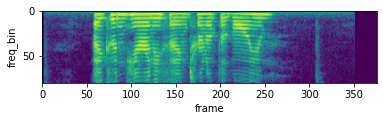

In [100]:
sample = test_ds[idx][0][0]
plt.xlabel('frame')
plt.ylabel('freq_bin')
plt.imshow(np.log(torchaudio.transforms.Spectrogram(n_fft=160)(sample).numpy()+1e-5))
plt.savefig('Espectro_100(2).png',dpi=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


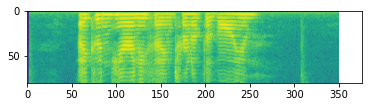

In [101]:
obj = torchaudio.transforms.Spectrogram(n_fft=160)
spectro = np.log(obj(test_ds[idx][0][0]))
plt.imshow(spectro)

In [102]:
epoch_arr=[0,1,2,3,4,5,6,7,8,9,10,11]

In [79]:
Results=torch.tensor([[0, 4.670018529365076, 6.013314888466194,  4.040157039960225,  12.101239124703401]
 ,[1, 2.7859092852028695, 33.40826560608681,  2.5376511732737224,  39.045610334827316]
 ,[2, 1.6691107196702484, 58.209406882241055,  1.6932682911554973,  55.391510677563936]
 ,[3, 1.142788059474355, 70.78938267335293,  1.232052779197693,  66.62272607434748]
 ,[4, 0.8568150269392446, 78.1601245028532,  1.4704358339309693,  60.9807540205642]
 ,[5, 0.6598331849219391, 83.32612830710704,  0.9969654182593027,  72.52834168204588]
 ,[6, 0.5169499526366345, 87.24710357945703,  0.8300639828046162,  76.77300290007909]
 ,[7, 0.40034285706380457,  90.62337886909908,  0.6862723896900813,  80.7540205641972]
 ,[8, 0.32011783765165847,  92.90160816185372,  0.6158225705226262,  82.65225415238598]
 ,[9, 0.2523016514287469,  94.72159778661594,  0.5643671582142512, 84.62958080674927]]).float()

In [109]:
rr_train_loss_1=[4.626157964790724,
  2.6436185586518346,
  1.596174125513319,
  1.1097272492904031,
  0.8137602302250941,
  0.6272458834213447,
  0.4813366794125151,
  0.38190358070378805,
  0.29749634960738336,
  0.23209740081544739,
  0.1765543263590797,
  0.1385402227263095]
rr_test_loss_1=[3.9043201923370363,
  2.4984984159469605,
  1.747256835301717,
  1.3717193802197774,
  1.1103356997172038,
  1.149321977297465,
  1.0636115650335947,
  0.7186287403106689,
  0.713772322734197,
  0.5842301577329636,
  0.599913889169693,
  0.5758607963720958]
rr_train_acc_1=[7.180529137126059,
  36.222548850077814,
  59.92996714508041,
  71.56752550579284,
  79.49593636520837,
  84.3809441466367,
  88.509424174304,
  91.04271139546948,
  93.60625972678541,
  95.2619747535881,
  96.94795089054124,
  97.9076603838838]
rr_test_acc_1=[13.076720274189297,
  39.493804376483,
  54.811494858950695,
  63.221724228842604,
  69.47007645663064,
  67.62457157922489,
  70.20827840759293,
  79.14579488531506,
  80.14764039019246,
  83.33772739256526,
  84.39230160822568,
  84.28684418665964]

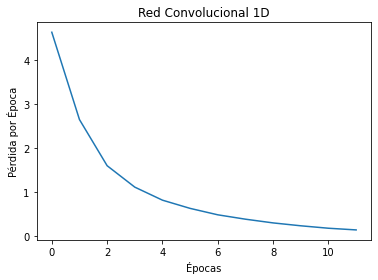

In [115]:
plt.plot(epoch_arr,rr_train_loss_1)
plt.xlabel('Épocas')
plt.ylabel('Error en entrenamiento')
#plt.title('Red Convolucional 1D')
plt.show()

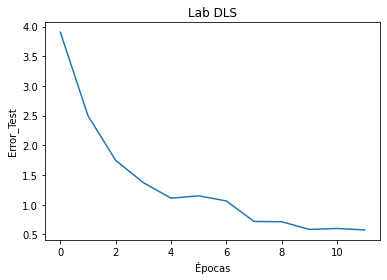

In [111]:
plt.plot(epoch_arr,rr_test_loss_1)
plt.xlabel('Épocas')
plt.ylabel('Error en Test')
#plt.title('Red Convolucional 1D')
plt.show()

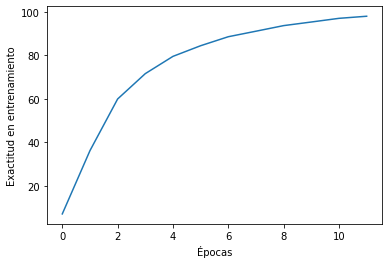

<Figure size 432x288 with 0 Axes>

In [120]:
plt.plot(epoch_arr,rr_train_acc_1)
plt.xlabel('Épocas')
plt.ylabel('Exactitud en entrenamiento')
#plt.title('Lab DLS')
plt.show()
plt.savefig('Exactitud_entrenamiento.png',dpi=100)

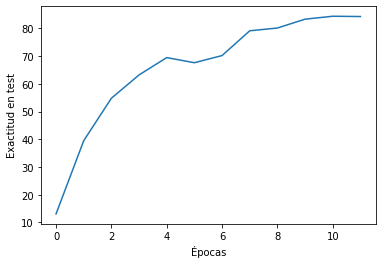

<Figure size 432x288 with 0 Axes>

In [136]:
plt.plot(epoch_arr,rr_test_acc_1)
plt.xlabel('Épocas')
plt.ylabel('Exactitud en test')
plt.show()
plt.savefig('Exactitud_test.png',dpi=100)

In [114]:
torch.save(model.state_dict(),"proyecto3.ckpt")